# Implemented augmentation processing

In [1]:
import cv2
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image, ImageOps

## 0. Prepare for augmentation  
 Prepare image and bounding box.

### 0.1 Prepare image

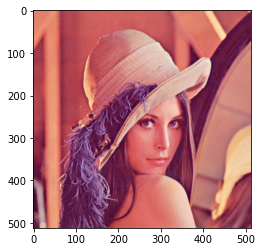

In [2]:
image_path = './lena_color.tiff'
# read image as rgb format
origin_image = cv2.imread(image_path)[:,:,::-1]
plt.imshow(origin_image)
plt.show()

### 0.2 Prepare bounding box

In [3]:
bboxes = np.array([[230, 220, 350, 390], [0, 0, 50, 50], [462, 462, 512, 512]], np.float32)

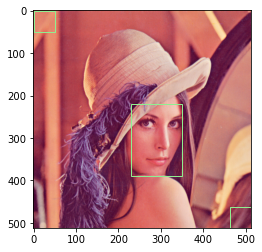

In [4]:
fig = plt.figure()
ax = plt.axes()
ax.imshow(origin_image)
for bbox in bboxes:
    r = patches.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2] - bbox[0], height=bbox[3] - bbox[1], color='lightgreen', fill=False)
    ax.add_patch(r)
plt.show()

## 1. Implement common processing

In [5]:
def _to_homogeneous_matrix(bboxes):
    _bboxes = []
    for bbox in bboxes:
        elements = []
        elements.append(list((bbox[0], bbox[1])))
        elements.append(list((bbox[2], bbox[1])))
        elements.append(list((bbox[0], bbox[3])))
        elements.append(list((bbox[2], bbox[3])))
        _bboxes.append(elements)
    _bboxes = np.array(_bboxes)
    bbox_matrix = np.concatenate([_bboxes, np.ones((_bboxes.shape[0],_bboxes.shape[1],1), np.float32)], axis=-1)
    return bbox_matrix

In [6]:
def _convert_format(bboxes):
    converted_bboxes = []
    for bbox in bboxes:
        elements = []
        elements.append(np.min(bbox[:,0]))
        elements.append(np.min(bbox[:,1]))
        elements.append(np.max(bbox[:,0]))
        elements.append(np.max(bbox[:,1]))
        elements = [int(elem) for elem in elements]
        converted_bboxes.append(elements)
    return np.array(converted_bboxes)

In [7]:
def _affine_transformation(image, bboxes, affine, w, h):
    transform_image = cv2.warpAffine(image, affine, (w, h), cv2.INTER_LANCZOS4) 
    bbox_matrix = _to_homogeneous_matrix(bboxes)
    tmp_bboxes = np.tensordot(affine, bbox_matrix.T, 1).T
    transform_bboxes = _convert_format(tmp_bboxes).clip(min=0, max=w)
    flag = (transform_bboxes[:, 0] != transform_bboxes[:, 2])\
                 & (transform_bboxes[:, 1] != transform_bboxes[:, 3])
    within_bboxes = transform_bboxes[flag]
    if within_bboxes.shape[0] == 0:
        return image, bboxes
    else:
        return transform_image, within_bboxes

In [8]:
def visualize(image, bboxes):
    fig = plt.figure()
    ax = plt.axes()
    ax.imshow(image)
    for bbox in bboxes:
        r = patches.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2] - bbox[0], height=bbox[3] - bbox[1], color='lightgreen', fill=False)
        ax.add_patch(r)
    plt.show()

## 2. Augmentation using affine transformation

### 2.1 translate

In [9]:
def translate(image, bboxes, shifts):
    shifts_array = np.array(shifts)
    h, w = image.shape[:2]
    src = np.array([[0.0, 0.0],[0.0, 1.0],[1.0, 0.0]], np.float32)
    dest = src + shifts_array.reshape(1,-1).astype(np.float32)
    affine = cv2.getAffineTransform(src, dest)
    return _affine_transformation(image, bboxes, affine, w, h)

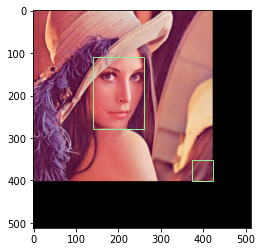

In [10]:
translated_image, translated_bboxes = translate(origin_image, bboxes, (-90, -110))
visualize(translated_image, translated_bboxes)

### 2.2 Scale

In [11]:
def random_scale(image, bboxes, ratio):
    h, w = image.shape[:2]
    scaled_center_h = (h / 2) * ratio
    scaled_center_w = (w / 2) * ratio
    diff = np.array((scaled_center_w - w / 2, scaled_center_h - h / 2))
    src = np.array([[0.0, 0.0],[0.0, 1.0],[1.0, 0.0]], np.float32)
    dest = src * ratio
    dest -= diff.reshape(1,-1).astype(np.float32)
    affine = cv2.getAffineTransform(src, dest)
    return _affine_transformation(image, bboxes, affine, w, h)

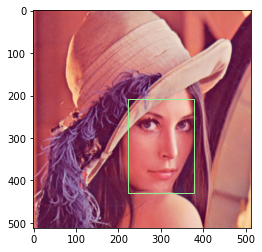

In [12]:
scaled_image, scaled_bboxes = random_scale(origin_image, bboxes, 1.3)
visualize(scaled_image, scaled_bboxes)

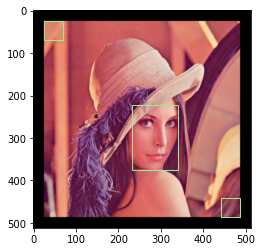

In [13]:
scaled_image, scaled_bboxes = random_scale(origin_image, bboxes, 0.9)
visualize(scaled_image, scaled_bboxes)

### 2.3 Flip

#### 2.3.1 Horizontally flip

In [14]:
def horizontal_flip(image, bboxes):
    h, w = image.shape[:2]
    src = np.array([[0.0, 0.0],[0.0, 1.0],[1.0, 0.0]], np.float32)
    dest = src.copy()
    dest[:,0] = w - src[:,0] 
    affine = cv2.getAffineTransform(src, dest)
    return _affine_transformation(image, bboxes, affine, w, h)

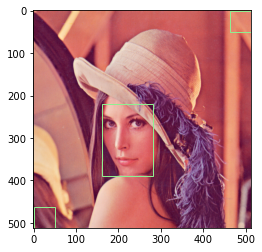

In [15]:
flipped_image, flipped_bboxes = horizontal_flip(origin_image, bboxes)
visualize(flipped_image, flipped_bboxes)

#### 2.3.2 Vertically flip

In [16]:
def vertical_flip(image, bboxes):
    h, w = image.shape[:2]
    src = np.array([[0.0, 0.0],[0.0, 1.0],[1.0, 0.0]], np.float32)
    dest = src.copy()
    dest[:,1] = h - src[:,1] 
    affine = cv2.getAffineTransform(src, dest)
    return _affine_transformation(image, bboxes, affine, w, h)

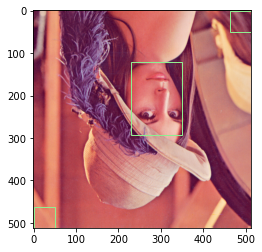

In [17]:
flipped_image, flipped_bboxes = vertical_flip(origin_image, bboxes)
visualize(flipped_image, flipped_bboxes)

### 2.4 Shear

#### 2.4.1 Shear along the x-axis

In [18]:
def shear_x(image, bboxes, angle):
    h, w = image.shape[:2]
    tan = math.tan(math.radians(abs(angle)))
    shear_x = tan * w
    src = np.array([[0.0, 0.0],[0.0, 1.0],[1.0, 0.0]], np.float32)
    dest = src.copy()
    if angle >= 0:
        dest[:, 0] += (shear_x / h * (h - src[:,1])).astype(np.float32)
        dest[:, 0] *= w / (w + h * tan)
    else:
        dest[:, 0] += (shear_x / h * src[:,1]).astype(np.float32)
        dest[:, 0] *= w / (w + h * tan)
    affine = cv2.getAffineTransform(src, dest)
    return _affine_transformation(image, bboxes, affine, w, h)

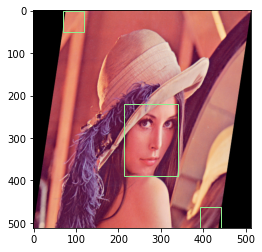

In [19]:
sheared_image, sheared_bboxes = shear_x(origin_image, bboxes, 10)
visualize(sheared_image, sheared_bboxes)

#### 2.4.2 Shear along the y-axis

In [20]:
def shear_y(image, bboxes, angle):
    h, w = image.shape[:2]
    tan = math.tan(math.radians(abs(angle)))
    shear_y = tan * h
    src = np.array([[0.0, 0.0],[0.0, 1.0],[1.0, 0.0]], np.float32)
    dest = src.copy()
    if angle >=0:
        dest[:, 1] += (shear_y / w * (w - src[:,0])).astype(np.float32)
    else:
        dest[:, 1] += (shear_y / w * src[:,0]).astype(np.float32)
    dest[:, 1] *= h / (h + w * tan)
    affine = cv2.getAffineTransform(src, dest)
    return _affine_transformation(image, bboxes, affine, w, h)

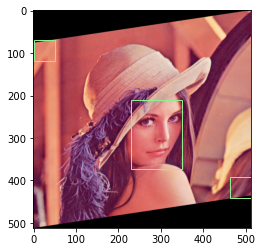

In [21]:
sheared_image, sheared_bboxes = shear_y(origin_image, bboxes, 10)
visualize(sheared_image, sheared_bboxes)

### 2.5 Rotation

In [22]:
def rotation(image, bboxes, angle):
    h, w = image.shape[:2]
    affine = cv2.getRotationMatrix2D((w/2.0, h/2.0), angle, 1.0)
    return _affine_transformation(image, bboxes, affine, w, h)

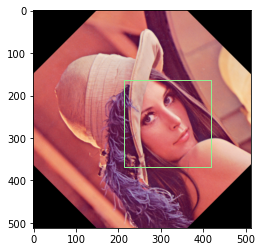

In [23]:
rotated_image, rotated_bboxes = rotation(origin_image, bboxes, 45)
visualize(rotated_image, rotated_bboxes)

## 3. Augmentation using adjust visual effect

### 3.1 Histogram equalization

#### 3.1.1 Simple histogram equalization

In [24]:
def histogram_equalize(image, bboxes):
    hsv_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV) 
    hsv_img[:,:,2] = cv2.equalizeHist(hsv_img[:,:,2])
    dest_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
    return dest_img, bboxes

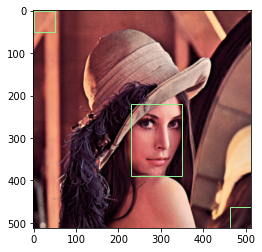

In [25]:
adjusted_image, adjusted_bboxes = histogram_equalize(origin_image, bboxes)
visualize(adjusted_image, adjusted_bboxes)

#### 3.1.2 Contrast limited adaptive histogram equalization

In [26]:
def clahe(image, bboxes):
    hsv_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8,8))
    hsv_img[:,:,2] = clahe.apply(hsv_img[:,:,2])
    dest_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
    return dest_img, bboxes

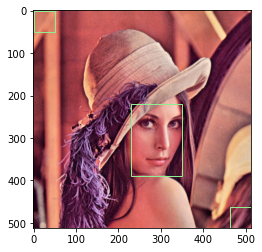

In [27]:
adjusted_image, adjusted_bboxes = clahe(origin_image, bboxes)
visualize(adjusted_image, adjusted_bboxes)

### 3.2 Adjust hue

In [28]:
def adjust_hue(image, bboxes, angle):
    hsv_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv_img = hsv_img.astype(np.uint16)
    hsv_img[:, :, 0] = (hsv_img[:, :, 0] + angle) % 180
    hsv_img = hsv_img.astype(np.uint8)
    dest_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
    return dest_img, bboxes

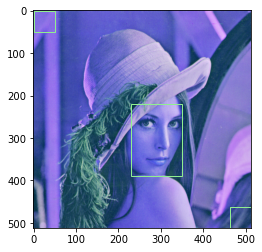

In [29]:
adjusted_image, adjusted_bboxes = adjust_hue(origin_image, bboxes, 120)
visualize(adjusted_image, adjusted_bboxes)

### 3.3 Adust saturation

In [30]:
def adjust_saturation(image, bboxes, magnification):
    hsv_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv_img = hsv_img.astype(np.uint16)
    hsv_img[:, :, 1] = hsv_img[:, :, 1] * magnification
    hsv_img = hsv_img.astype(np.uint8)
    dest_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
    return dest_img, bboxes

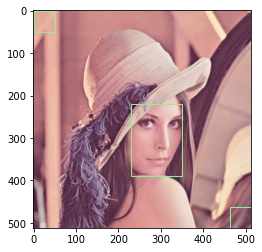

In [31]:
adjusted_image, adjusted_bboxes = adjust_saturation(origin_image, bboxes, 0.6)
visualize(adjusted_image, adjusted_bboxes)

### 3.4 Adust value

In [32]:
def adjust_value(image, bboxes, magnification):
    hsv_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv_img = hsv_img.astype(np.uint16)
    hsv_img[:, :, 2] = hsv_img[:, :, 2] * magnification
    hsv_img = hsv_img.astype(np.uint8)
    dest_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
    return dest_img, bboxes

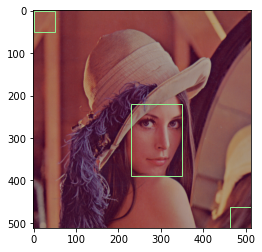

In [33]:
adjusted_image, adjusted_bboxes = adjust_value(origin_image, bboxes, 0.7)
visualize(adjusted_image, adjusted_bboxes)

### 3.5 Auto contrast ( __not implemented__ )

In [34]:
def auto_contrast(image, bboxes, cutoff=1.0):
    pil_img = Image.fromarray(image.astype(np.uint8))
    dest_pil_img = ImageOps.autocontrast(pil_img, cutoff)
    dest_ary_img = np.asarray(dest_pil_img)
    return dest_ary_img, bboxes

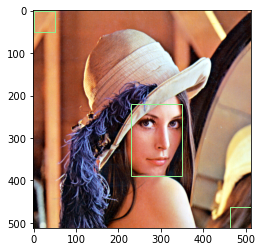

In [35]:
adjusted_image, adjusted_bboxes = auto_contrast(origin_image, bboxes, 1.0)
visualize(adjusted_image, adjusted_bboxes)